In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

# Data Statistics
We will show some descriptive statistics of collections. A sparsity plot will show which user-item matrix should we choose. 

## 0.Helper functions
Before we go on, we define some useful functions.<br>
1. __get__ functions
- item dictionary
- user dictionary
- sparsity
2. __distribution__ functions
- item distribution
- user distribution
3. __conditional__ functions
- item dictionary of N users transactions condition
- user dictionary of N users transactions condition
4. __plot sparsity__ functions
- plot sparsity with users
- plot sparsity with items

In [11]:
# Getting a user-item dictionary from DataFrame
def get_item_dict(df, name):
    """
    generates a item-user dictionary for one collection
    
    INPUT
        df: (pandas DataFrame) csv file
        name: (str) collection name
    OUTPUT
        item_dict: (dictionary) {item: user1, user2, ...}
    """
    from tqdm import tqdm
    item_dict = defaultdict(list)
    user_i = []
    
    items = df["tokenID"].unique()
    for i in tqdm(items):
        user_i = []
        df_i = df[df["tokenID"] == i]
        # user_i.extend(df_i["from"].unique())
        user_i.extend(df_i["to"].unique())
        asset_name = name + "/" + str(i)
        item_dict[asset_name] = user_i
    return item_dict

def get_user_dict(df, name):
    """
    generates a user-item dictionary for one collection
    
    INPUT
        df: (pandas DataFrame) csv file
        name: (str) collection name
    OUTPUT
        user_dict: (dictionary) {user: item1, item2, ...}
    """
    from tqdm import tqdm
    user_dict = defaultdict(list)
    user_i = []
    
    to_users = df["to"].unique()
    for i in tqdm(to_users):
        item_i = []
        df_i = df[df["to"] == i]
        item_i.extend(df_i["tokenID"].unique())
        for z, j in enumerate(item_i):
            asset_name = name + "/" + str(j)
            item_i[z] = asset_name
        if user_dict[i] == []:
            user_dict[i] = item_i
        else:
             user_dict[i].extend(item_i)
        
    return user_dict

# Sparsity
def get_sparsity(item_dict, user_dict):
    """
    sparsity of a user-item matrix
    
    INPUT
        item_dict: (dictionary) key -> item
        user_dict: (dictionary) key -> user
    OUTPUT
        sparsity: (float)
    """
    
    total_elements = len(item_dict) * len(user_dict)
#     print("total_elements:",total_elements)
    
    stats = []
    for item in item_dict.keys():
        users = item_dict[item]
        stats.append(len(users))
    
    count = sum(stats)
#     print("count:",count)
    
    # Sparsity
    sparsity = 1 - count / total_elements
    return sparsity

In [15]:
# Producing a statistics and plot a distribution
def item_distribution(item_dict, name):
    item_dist = defaultdict(int)
    stats = []

    for item in tqdm(item_dict.keys()):
        users = item_dict[item]
        item_dist[item] = len(users)
        stats.append(len(users))

    # Statistics
    mean = np.mean(stats)
    std = np.std(stats)
    median = np.median(stats)
    print("mean:", mean, ", std:",std)
    print("median:", median)

    # Plot
    plt.hist(stats, color='b', alpha=0.5, bins=50)
    plt.xlabel("transaction users for each items")
    plt.ylabel("# of items")
    plt.title(name)
    plt.show()
    
    return item_dist, (mean, std, median)

def user_distribution(user_dict, name):
    user_dist = defaultdict(int)
    stats = []

    for user in tqdm(user_dict.keys()):
        items = user_dict[user]
        user_dist[user] = len(items)
        stats.append(len(items))

    # Statistics
    mean = np.mean(stats)
    std = np.std(stats)
    median = np.median(stats)
    print("mean:", mean, ", std:",std)
    print("median:", median)

    # Plot
    plt.hist(stats, color='b', alpha=0.5, bins=50)
    plt.xlabel("transaction items for each users")
    plt.ylabel("# of users")
    plt.title(name)
    plt.show()
    
    return user_dist, (mean, std, median)

In [34]:
# Getting a N user-item dictionary from the raw user-item dictionary.
def get_item_dict_N_user_condition(item_dict, N):
    """
    generates a item-user dictionary conditioned on at least N users transaction.
    item_dict is required for getting it.
    
    INPUT
        item_dict: (dictionary) key -> item
        N: (int) at least N users transaction
    OUTPUT
        Nitem_dict: (dictionary)
    """
    Nitem_dict = defaultdict(list)
    
    for item in item_dict.keys():
        n_users = len(item_dict[item])
        if n_users >= N:
            Nitem_dict[item] = item_dict[item]

    return Nitem_dict

def get_user_dict_N_user_condition(Nitem_dict):
    """
    generates a user-item dictionary conditioned on at least N users transaction.
    Nitem_dict is required for getting it.
    
    INPUT
        Nitem_dict: (dictionary) key -> item
    OUTPUT
        Nuser_dict: (dictionary)
    """
    Nuser_dict = defaultdict(list)
    
    from itertools import chain
    users = list(set(chain.from_iterable(Nitem_dict.values())))
    
    for u in users:
        for token_id in Nitem_dict.keys():
            address = list(Nitem_dict[token_id])
            if u in address:
                Nuser_dict[u].append(token_id)
    
    return Nuser_dict

# Getting a N user-item dictionary, statistics and sparsity
def Nitem_user_dicts(item_dict, N):
    # Conditional dictionaries
    Nitem_dict = get_item_dict_N_user_condition(item_dict, N)
    Nuser_dict = get_user_dict_N_user_condition(Nitem_dict)
    
    # Conditional distributions
    Nitem_dist, Nitem_stat = item_distribution(Nitem_dict, f"at least {N}")
    Nuser_dist, Nuser_stat = user_distribution(Nuser_dict, f"at least {N}")
    
    # Sparsity
    sparsity_Ncondition = get_sparsity(Nitem_dict, Nuser_dict)
    print(sparsity_Ncondition)
    
    return Nitem_dict, Nuser_dict, sparsity_Ncondition

In [113]:
def plot_sparsity_with_users(Nsparsity, Nusers=None):
    fig1, ax1 = plt.subplots(figsize=(10,6))

    Ns = list(range(1,len(Nsparsity)+1))

    line1 = ax1.plot(Ns, Nsparsity, "bo-", label="sparsity")
    ax1.grid(True, axis="y", color='black', alpha=0.5, linestyle='--')
    ax1.set_ylabel("Sparsitiy")
    ax1.grid(True, axis="y", color='black', alpha=0.5, linestyle='--')
    
    if Nusers is not None:
        Nus = []
        for n_user in Nusers:
            Nus.append(len(n_user))
        ax2 = ax1.twinx()
        line2 = ax2.plot(Ns, Nus,"co-", alpha=0.5, label="num_users")
        ax2.set_ylabel("# of users")
        
        # labels
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc="best")
            
    plt.xticks(Ns)
    plt.title("at least N users transaction per item")
    plt.xlabel("N")
    plt.show()

def plot_sparsity_with_items(Nsparsity, Nitems=None):
    fig1, ax1 = plt.subplots(figsize=(10,6))

    Ns = list(range(1,len(Nsparsity)+1))

    line1 = ax1.plot(Ns, Nsparsity, "bo-", label="sparsity")
    ax1.grid(True, axis="y", color='black', alpha=0.5, linestyle='--')
    ax1.set_ylabel("Sparsitiy")
    ax1.grid(True, axis="y", color='black', alpha=0.5, linestyle='--')
    
    if Nitems is not None:
        Nis = []
        for n_item in Nitems:
            Nis.append(len(n_item))
        ax2 = ax1.twinx()
        line2 = ax2.plot(Ns, Nis,"yo-", alpha=0.5, label="num_items")
        ax2.set_ylabel("# of items")
        
        # labels
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax1.legend(lines, labels, loc="best")
            
    plt.xticks(Ns)
    plt.title("at least N users transaction per item")
    plt.xlabel("N")
    plt.show()

## 1.Loading data

In [4]:
# Load data
df_bayc = pd.read_csv("data/BAYC.csv")
df_meebits = pd.read_csv("data/MEEBITS.csv")
df_doodles = pd.read_csv("data/DOODLES.csv")
df_azuki = pd.read_csv("data/AZUKI.csv")
df_coolcats = pd.read_csv("data/COOLCATS.csv")

collections = [df_bayc, df_meebits, df_doodles, df_azuki, df_coolcats]
coll_name = ["Bayc", "Meebits", "Doodles", "Azuki", "Coolcats"]

## 2.Whole collections descriptive statistics

In [9]:
collections = [df_bayc, df_meebits, df_doodles, df_azuki, df_coolcats]
coll_name = ["Bayc", "Meebits", "Doodles", "Azuki", "Coolcats"]

whole_item_dict = defaultdict(list)
whole_user_dict = defaultdict(list)

for nft, name in zip(collections, coll_name):
    whole_item_dict.update(get_item_dict(nft, name))
for nft, name in zip(collections, coll_name):
    whole_user_dict.update(get_user_dict(nft, name))
    
# print
print(dict(list(whole_item_dict.items())[0:3]))
print(dict(list(whole_user_dict.items())[0:3]))

100%|██████████| 5991/5991 [00:04<00:00, 1336.15it/s]

{'Bayc/321': ['0x710f6e3bfc837f451efb2955feedaf8a601bbfb6', '0x2a59d2927541d17c0fa19140703ecb4b697b765d', '0x95c6d0f794b9c629c94b1cbd9bbf4c290d326f99'], 'Bayc/4785': ['0xa8340d926c0ea053b5d8a0cf53aacf4ee4120f86', '0xa282017d04148a8f5623461838aef2dc58054a72'], 'Bayc/9355': ['0xa742203fe554fff075077b749f5402c62fc01bba', '0x13d8faf4a690f5ae52e2d2c52938d1167057b9af', '0x6449bbb550f1049236d803f0e43759999b9a2bee', '0x2f727a6fc4b10df56a1f7d63480d8ae9b8a6f859']}
{'0x710f6e3bfc837f451efb2955feedaf8a601bbfb6': ['Bayc/321'], '0xa8340d926c0ea053b5d8a0cf53aacf4ee4120f86': ['Bayc/4785'], '0xa282017d04148a8f5623461838aef2dc58054a72': ['Bayc/4785']}


In [17]:
print("total users:", len(whole_user_dict))
print("total items:", len(whole_item_dict))

total users: 19976
total items: 18065


In [12]:
print("whole cllections sparsity:", get_sparsity(whole_item_dict, whole_user_dict))

whole cllections sparsity: 0.9998808007749349


100%|██████████| 18065/18065 [00:00<00:00, 2060762.12it/s]


mean: 2.38112371990036 , std: 3.2105983086491885
median: 2.0


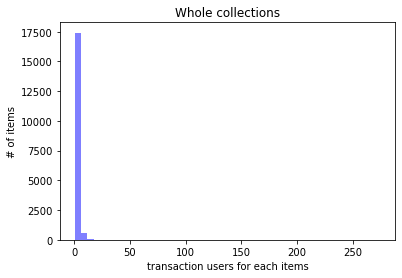

100%|██████████| 19976/19976 [00:00<00:00, 1943345.94it/s]


mean: 1.7034441329595515 , std: 6.674490147918733
median: 1.0


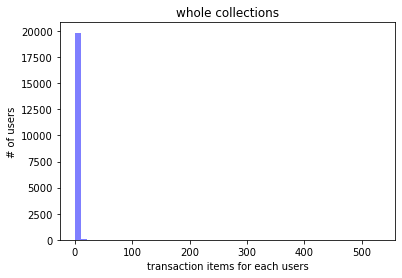

In [16]:
whole_item_dist, item_stat = item_distribution(whole_item_dict, "Whole collections")
whole_user_dist, user_stat = user_distribution(whole_user_dict, "whole collections")

## 3.(At least) N users transaction descriptive statistics

100%|██████████| 2061/2061 [00:00<00:00, 2342037.54it/s]

mean: 6.630276564774381 , std: 7.924751353128207
median: 6.0


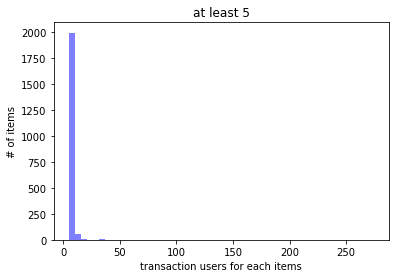

100%|██████████| 6974/6974 [00:00<00:00, 1800620.26it/s]


mean: 1.959420705477488 , std: 15.022349834820893
median: 1.0


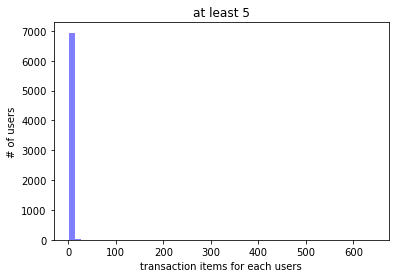

0.9990492864117043


In [33]:
# Conditional dictionaries
item_dict5 = get_item_dict_N_user_condition(whole_item_dict, 5)
user_dict5 = get_user_dict_N_user_condition(item_dict5)

# Conditional distributions
item_dist5, item_stat5 = item_distribution(item_dict5, "at least 5")
user_dist5, user_stat5 = user_distribution(user_dict5, "at least 5")

# Sparsity
sparsity_5condition = get_sparsity(item_dict5, user_dict5)
print(sparsity_5condition)

100%|██████████| 18065/18065 [00:00<00:00, 2515607.63it/s]

mean: 2.38112371990036 , std: 3.2105983086491885
median: 2.0


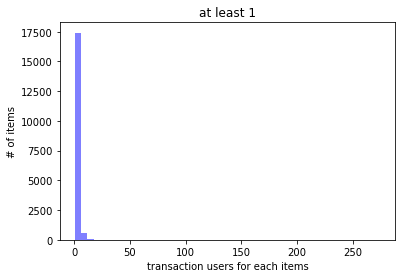

100%|██████████| 19976/19976 [00:00<00:00, 1830015.22it/s]

mean: 2.153334000800961 , std: 12.915713130624434
median: 1.0


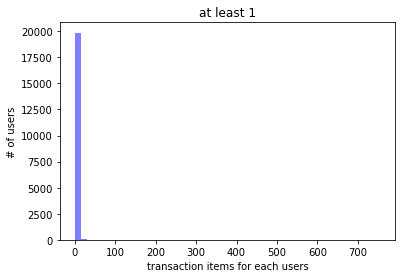

0.9998808007749349


100%|██████████| 10455/10455 [00:00<00:00, 2564412.18it/s]

mean: 3.386417981826877 , std: 3.925792665068744
median: 3.0


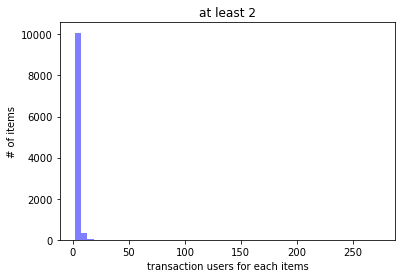

100%|██████████| 16826/16826 [00:00<00:00, 1915048.28it/s]


mean: 2.104184000950909 , std: 13.398118906922972
median: 1.0


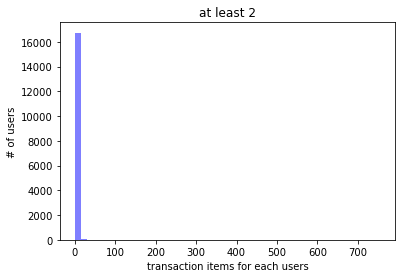

0.9997987389764753


100%|██████████| 5686/5686 [00:00<00:00, 2573798.03it/s]

mean: 4.549243756595146 , std: 5.037246282840566
median: 4.0


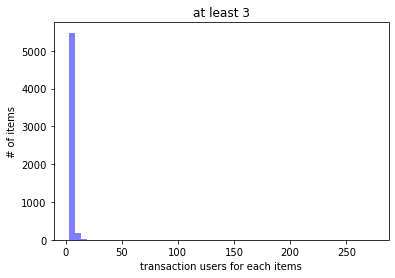

100%|██████████| 12644/12644 [00:00<00:00, 1809374.95it/s]


mean: 2.0457924707371085 , std: 14.273147963246284
median: 1.0


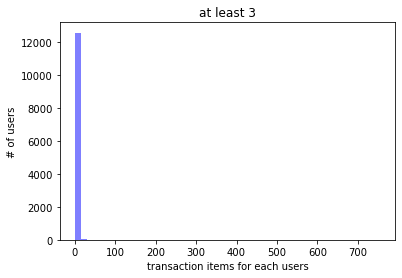

0.9996402053340244


100%|██████████| 3388/3388 [00:00<00:00, 2464071.78it/s]

mean: 5.600059031877214 , std: 6.312855832097373
median: 5.0


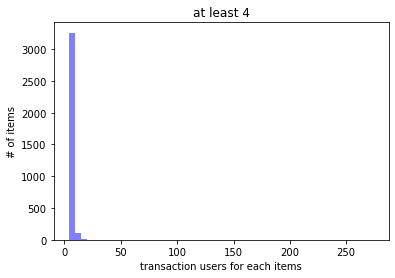

100%|██████████| 9459/9459 [00:00<00:00, 1803770.02it/s]


mean: 2.0058145681361665 , std: 15.171315042064993
median: 1.0


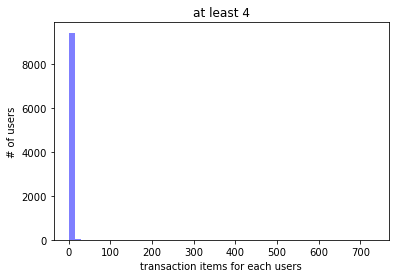

0.9994079650035017


100%|██████████| 2061/2061 [00:00<00:00, 2209164.46it/s]

mean: 6.630276564774381 , std: 7.924751353128207
median: 6.0


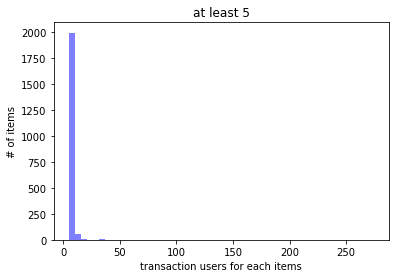

100%|██████████| 6974/6974 [00:00<00:00, 1914337.44it/s]


mean: 1.959420705477488 , std: 15.022349834820893
median: 1.0


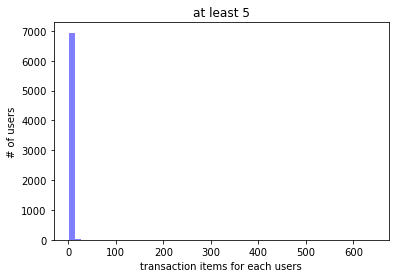

0.9990492864117043


100%|██████████| 1151/1151 [00:00<00:00, 2229858.62it/s]

mean: 7.919200695047785 , std: 10.425503617861656
median: 7.0


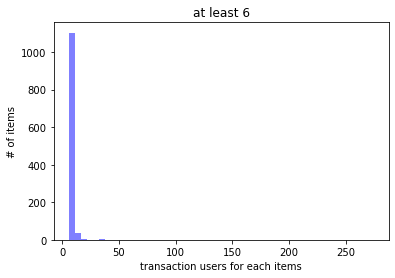

100%|██████████| 5029/5029 [00:00<00:00, 1953069.89it/s]


mean: 1.812487572081925 , std: 11.486322676386186
median: 1.0


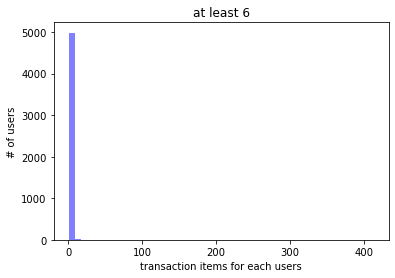

0.9984252931606586


100%|██████████| 647/647 [00:00<00:00, 1394509.09it/s]

mean: 9.414219474497681 , std: 13.720605178412404
median: 8.0


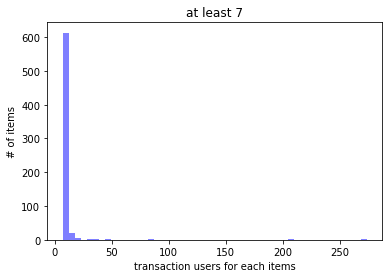

100%|██████████| 3656/3656 [00:00<00:00, 1694780.66it/s]


mean: 1.6660284463894968 , std: 8.486590348108523
median: 1.0


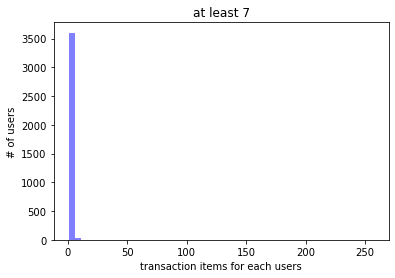

0.9974249946732774


100%|██████████| 375/375 [00:00<00:00, 908120.09it/s]

mean: 11.165333333333333 , std: 17.81877282219202
median: 9.0


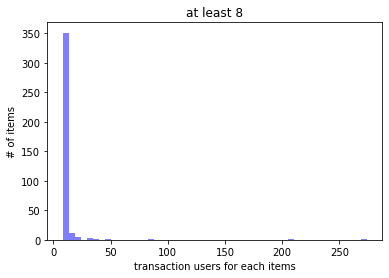

100%|██████████| 2780/2780 [00:00<00:00, 1733080.43it/s]


mean: 1.506115107913669 , std: 5.619496381694046
median: 1.0


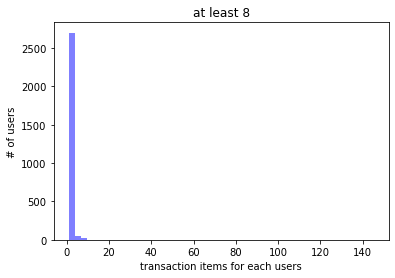

0.9959836930455636


100%|██████████| 209/209 [00:00<00:00, 1214140.63it/s]

mean: 13.679425837320574 , std: 23.567222547803663
median: 10.0


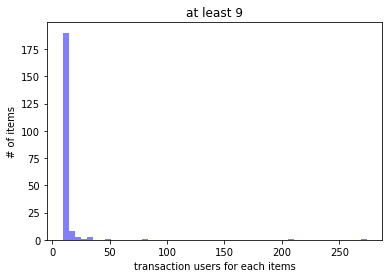

100%|██████████| 2091/2091 [00:00<00:00, 1715292.33it/s]


mean: 1.3672883787661405 , std: 3.5657332517618356
median: 1.0


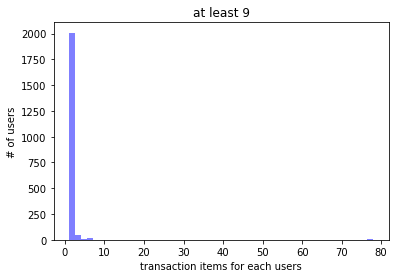

0.9934579503408318


100%|██████████| 129/129 [00:00<00:00, 352715.26it/s]

mean: 16.58139534883721 , std: 29.628631050015844
median: 11.0


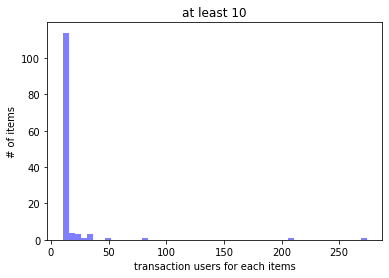

100%|██████████| 1663/1663 [00:00<00:00, 1693403.14it/s]

mean: 1.286229705351774 , std: 2.6419706310906887
median: 1.0


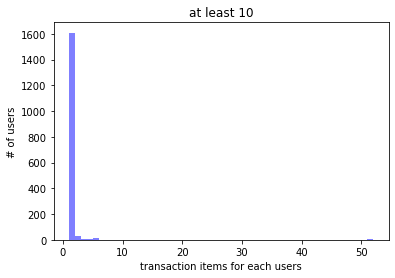

0.9900292270902963


100%|██████████| 70/70 [00:00<00:00, 589560.80it/s]

mean: 22.12857142857143 , std: 39.37617895870237
median: 12.0


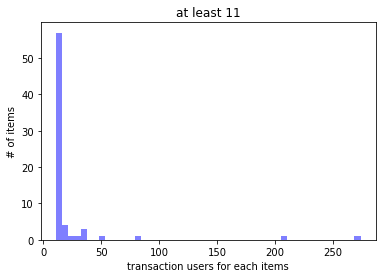

100%|██████████| 1331/1331 [00:00<00:00, 1808428.45it/s]

mean: 1.163786626596544 , std: 1.5997498197066176
median: 1.0


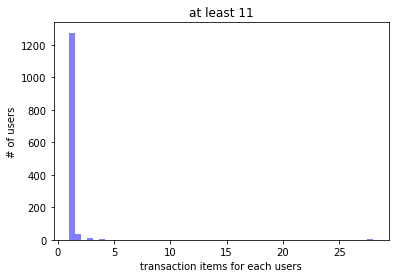

0.9833744767629066


100%|██████████| 48/48 [00:00<00:00, 694229.63it/s]


mean: 27.229166666666668 , std: 46.6727256111342
median: 13.5


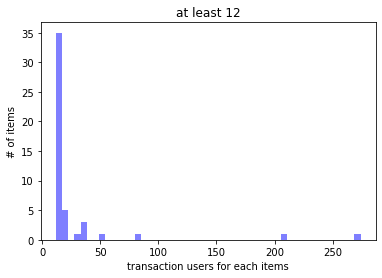

100%|██████████| 1168/1168 [00:00<00:00, 1663479.48it/s]

mean: 1.1190068493150684 , std: 1.2094300027119949
median: 1.0


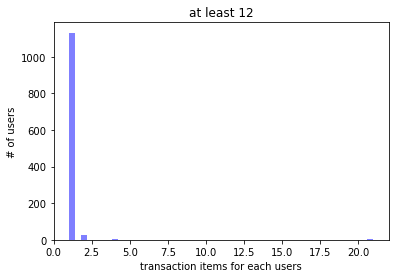

0.976687357305936


100%|██████████| 34/34 [00:00<00:00, 164293.01it/s]


mean: 33.5 , std: 54.22624174804711
median: 15.0


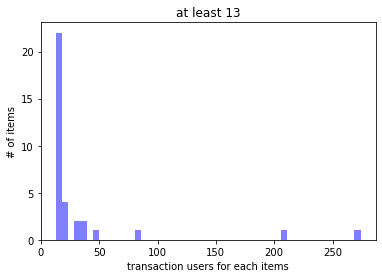

100%|██████████| 1066/1066 [00:00<00:00, 1639577.58it/s]

mean: 1.0684803001876173 , std: 0.8068660204397304
median: 1.0


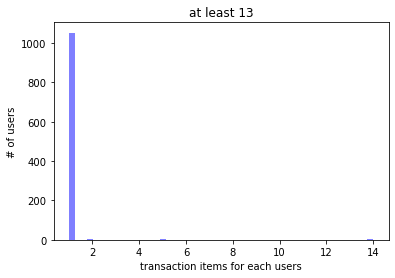

0.9685741088180113


100%|██████████| 24/24 [00:00<00:00, 443450.64it/s]


mean: 42.041666666666664 , std: 62.590919979569634
median: 18.5


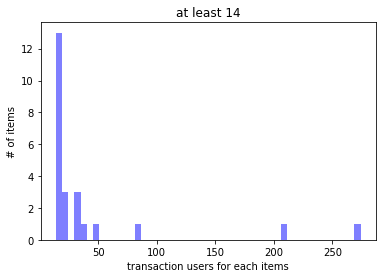

100%|██████████| 971/971 [00:00<00:00, 1543847.30it/s]

mean: 1.03913491246138 , std: 0.46340084514557695
median: 1.0


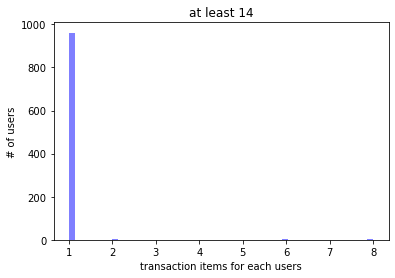

0.9567027119807758


100%|██████████| 19/19 [00:00<00:00, 150931.39it/s]


mean: 49.421052631578945 , std: 68.46306402531273
median: 21.0


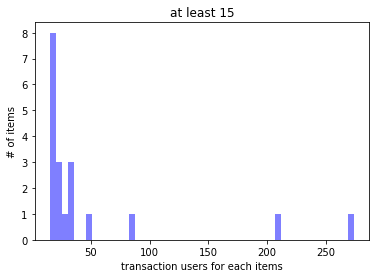

100%|██████████| 922/922 [00:00<00:00, 1570734.48it/s]

mean: 1.0184381778741864 , std: 0.21006803715564132
median: 1.0


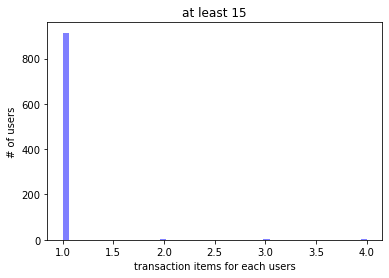

0.9463979906382007


100%|██████████| 15/15 [00:00<00:00, 81920.00it/s]


mean: 58.6 , std: 74.41039353925409
median: 30.0


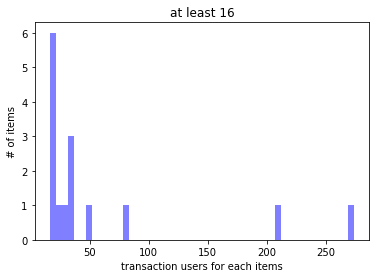

100%|██████████| 877/877 [00:00<00:00, 1426291.05it/s]

mean: 1.0022805017103762 , std: 0.04770011553786063
median: 1.0


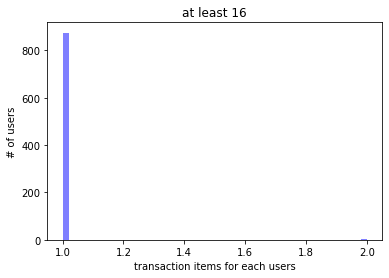

0.9331812998859749


100%|██████████| 13/13 [00:00<00:00, 133970.40it/s]


mean: 65.15384615384616 , std: 77.88832849648483
median: 33.0


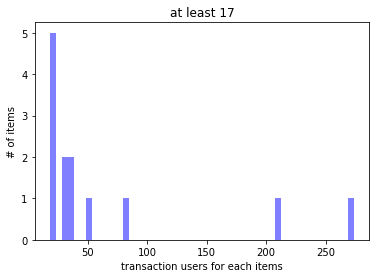

100%|██████████| 845/845 [00:00<00:00, 1578702.40it/s]

mean: 1.0023668639053254 , std: 0.04859281696484689
median: 1.0


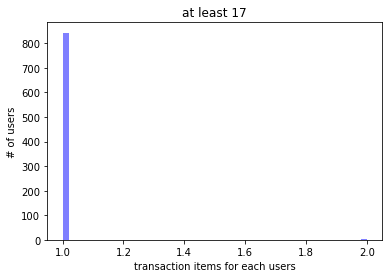

0.9228948566226672


100%|██████████| 13/13 [00:00<00:00, 98422.30it/s]


mean: 65.15384615384616 , std: 77.88832849648483
median: 33.0


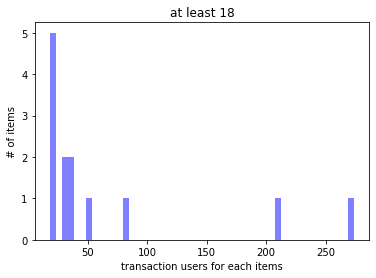

100%|██████████| 845/845 [00:00<00:00, 1832568.19it/s]

mean: 1.0023668639053254 , std: 0.04859281696484689
median: 1.0


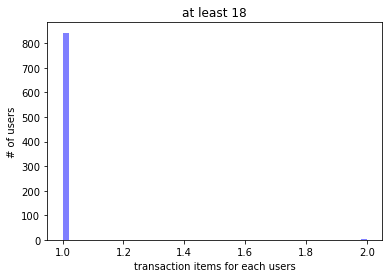

0.9228948566226672


100%|██████████| 12/12 [00:00<00:00, 65621.44it/s]


mean: 69.08333333333333 , std: 79.82111075537738
median: 33.5


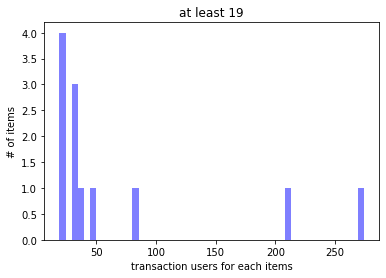

100%|██████████| 827/827 [00:00<00:00, 1448909.53it/s]

mean: 1.0024183796856105 , std: 0.04911752360723071
median: 1.0


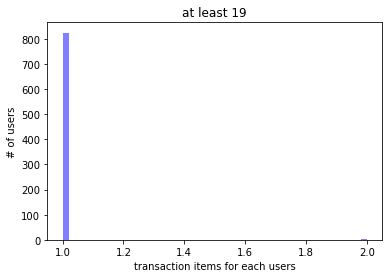

0.9164651350261991


100%|██████████| 11/11 [00:00<00:00, 215595.07it/s]

mean: 73.63636363636364 , std: 81.8649361362668
median: 34.0


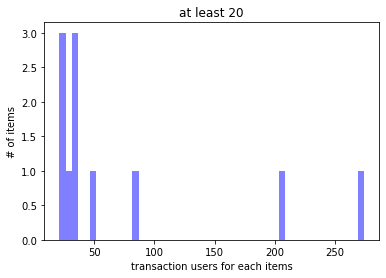

100%|██████████| 808/808 [00:00<00:00, 1816183.08it/s]

mean: 1.0024752475247525 , std: 0.0496902472769424
median: 1.0


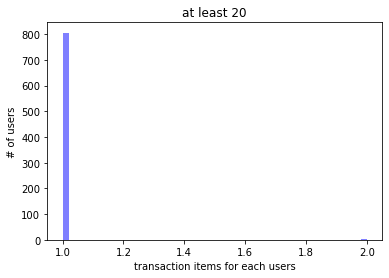

0.9088658865886589


In [79]:
Nitems = []
Nusers = []
Nsparsity = []

for n in range(1,21):
    n_item_dict, n_user_dict, n_sparsity = Nitem_user_dicts(whole_item_dict, n)
    Nitems.append(n_item_dict)
    Nusers.append(n_user_dict)
    Nsparsity.append(n_sparsity)

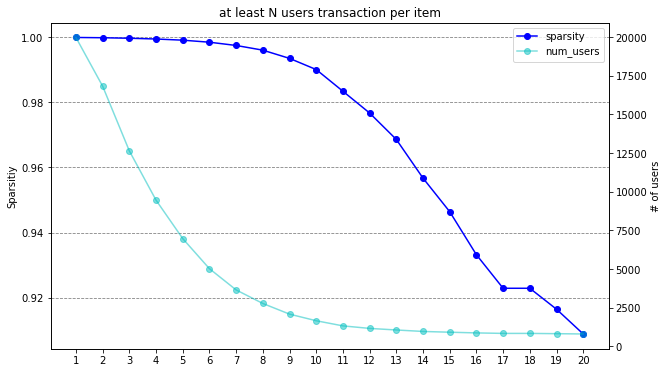

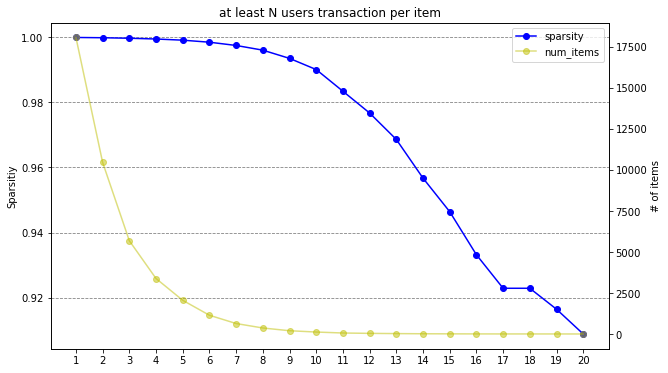

In [114]:
plot_sparsity_with_users(Nsparsity, Nusers)
plot_sparsity_with_items(Nsparsity, Nitems)